In [1]:
from datetime import datetime
from utils import get_pg_engine
import pandas as pd


In [2]:
def build_correlations(start_date = '2019-01-01', end_date = datetime.now().strftime('%Y-%m-%d'), num_stocks = 1000):
    

    assert num_stocks > 20, 'To build an interesting analysis, make sure the number of stocks to use is at least 20'

    start_date_fmt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_fmt = datetime.strptime(end_date, '%Y-%m-%d')
    diff = end_date_fmt - start_date_fmt
    assert int(diff.days/7) > 12, 'For more meaningful correlations increase the window between the start_date and end_date (at least 12 weeks)'

    engine = get_pg_engine()

    engine.execute("CREATE TABLE IF NOT EXISTS correlations (window_id text, start_date date, end_date date, symbol_a text, symbol_b text, correlation double precision)")

    stocks = pd.read_sql(f'select symbol, sum(volume) as volume \
                       from price \
                       where timestamp between \'{start_date}\' and \'{end_date}\' \
                       group by symbol \
                       order by sum(volume) desc \
                       limit {num_stocks}', engine)
    
    relevant_stocks = ','.join([f"'{stock}'" for stock in stocks['symbol'].tolist()])

    price_data = pd.read_sql(f"select timestamp, symbol, open as price\
                            from price\
                            where \"timestamp\" between \'{start_date}\' and \'{end_date}\'\
                            and symbol in ({relevant_stocks})", engine)

    price_data = price_data.pivot(index='timestamp', columns='symbol', values='price')

    return price_data
       

In [3]:
df = build_correlations()

In [9]:
df.isna().apply('mean').sort_values(ascending=False)

symbol
FRAS.LON    0.957265
ORIT.LON    0.948718
SIG.LON     0.931624
STEM.LON    0.931624
ZAIM.LON    0.923077
              ...   
AT1.LON     0.504274
WWH.LON     0.495726
IEM.LON     0.495726
CLDN.LON    0.495726
ANII.LON    0.495726
Length: 1000, dtype: float64

In [10]:
df['ANII.LON']

timestamp
2019-01-04    468.0000
2019-01-08         NaN
2019-01-11    472.0000
2019-01-18    451.0000
2019-01-25    452.0000
                ...   
2020-01-08         NaN
2020-01-09    462.0000
2020-01-10         NaN
2020-01-13    471.0099
2020-01-14         NaN
Name: ANII.LON, Length: 117, dtype: float64

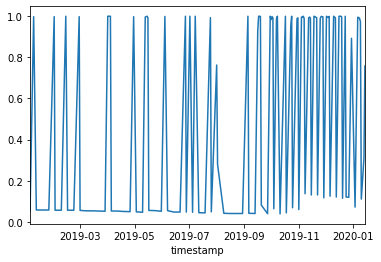

In [14]:
df.isna().apply('mean', axis=1).plot()

In [18]:
df.isna().apply('mean', axis=1).tail(25)

timestamp
2019-11-29    0.117
2019-12-02    0.999
2019-12-03    0.994
2019-12-04    0.993
2019-12-05    0.998
2019-12-06    0.125
2019-12-10    0.999
2019-12-12    0.991
2019-12-13    0.121
2019-12-16    0.999
2019-12-18    0.999
2019-12-19    0.996
2019-12-20    0.115
2019-12-23    0.999
2019-12-24    0.121
2019-12-27    0.120
2019-12-30    0.892
2020-01-03    0.072
2020-01-06    0.994
2020-01-07    0.993
2020-01-08    0.989
2020-01-09    0.973
2020-01-10    0.111
2020-01-13    0.311
2020-01-14    0.757
dtype: float64